# Example Notebook
## Conditional Amplitude Reflection Spin-Spin Entanglement

In this notebook we show how to construct a Protocol to simulate Spin-Spin Entanglement using a Conditional Amplitude Reflection SPI (See Section IV C 4 of [1]). This is Protocol C in [1].

## Setting up the protocol:

In [1]:
# Utility and common imports

import sys
from os.path import expanduser, join
home = expanduser("~")
sys.path.append(join(home, 'Repositories/2024.CQNSCHOOL.DIGITALTWIN'))
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

# QuREBB library imports

import lib.LBB as lbb
import lib.PBB as pbb
import lib.NQobj as nq
import lib.states as st
import lib.quantum_optical_modelling as qom
from lib.PBB import no_vacuum_projector
from lib.protocol import Protocol

First, we look at the Logical Building Blocks and Encoding.

![image.png](Images/qurebb_example_1.png))

We start with a single photon in Time-Bin encoding, prepared in $|+\rangle = 1/\sqrt{2}(|E\rangle + |L\rangle)$, and two spins Alice and Bob, both prepared in $|+\rangle=1/\sqrt{2}(|\uparrow\rangle + |\downarrow\rangle)$.

The photon then interacts with a Conditional Amplitude Reflection SPI based on a cavity-emitter system of Alice, then with the one of Bob.

To measure entanglement we need to measure the photonic qubit in the X basis, therefore we apply a rotation gate before we measure in the| $\{|E\rangle, |L\rangle\}$ basis.

We first create our protocol, inheriting from the Protocol class.
Here we need to define:


 - The initial density matrix of the spin state(s)
 - The projector of the photonic state we want to herald for successful entanglement
 - The target state of our protocol


Often different final photonic states correspond to a different entangled state generation. The protocol allows one to define a list of photon state projectors and target states. They have to correspond one-to-one, for each herald state the protocol calculates the fidelity of the corresponding target state.

Detecting a photon in $|E\rangle$ will herald the final Bell state $|\psi_+\rangle$, and detecting a photon in $|L\rangle$ will herald $|\psi_-\rangle$.
The detection is done using the projector on "non vacuum" state: $P = \mathbb{1} - |vac\rangle\langle vac |$.

In [2]:
class ExampleProtocol(Protocol):
    """ 
        Our protocol class to simulate Spin-Photon Entanglement
    """
    def __init__(self, parameters: dict):
        super().__init__(parameters)

        # We prepare the initial state of the spins in |x >
        self.dm_init = nq.tensor(nq.name(st.x_dm, "Alice", "state"), nq.name(st.x_dm, "Bob", "state"))

        # We definet the two herald state projectors.
        self.herald_projectors = [
            no_vacuum_projector(name="E", dim=self.dim),
            no_vacuum_projector(name="L", dim=self.dim),
        ]

        # And the corresponding target entangled states

        state_uu = nq.tensor(nq.name(st.up, "Alice", "state"), nq.name(st.up, "Bob", "state"))
        state_dd = nq.tensor(nq.name(st.down, "Alice", "state"), nq.name(st.down, "Bob", "state"))
        
        self.target_states = [
            (state_uu + state_dd).unit(), 
            (state_uu - state_dd).unit()
        ]
        

        
        

The Protocol class contains several built-in features, in particular:
 - parameters: a dictionary of the parameters needed to run the protocol
 - dm: the density matrix used for the evolution of the protocol
 - fidelity, rate: values that get updated with the simulation results

A key function of Protocol is the _do_lbb()_ function. This is a wrapper that applies a Logical Building Block to the density matrix, taking care to pass over all the relevant parameters.
It is defined like this:

In [3]:
    def do_lbb(self, LBB, **kwargs):
        """Makes a logical building block act on the density matrix."""
        kwargs.update(self.parameters)

        self.dm = LBB(dm_in=self.dm, **kwargs)

For example: let's start from the initial density matrix of our protocol, which contains only the spin states, and apply a photon source LBB to generate a photon in  $|+\rangle = 1/\sqrt{2}(|E\rangle + |L\rangle)$.

This is how the source is defined in the LBB library:

In [4]:
def photon_source_time_bin(dm_in, photon_early_name, photon_late_name, dim, alpha=None, **kw):
    # We can either create a single ephoton
    if alpha is None:
        photon_basis = st.photon(dim)

    # Or a coherent state
    else:
        photon_basis = qt.coherent(dim, alpha)

    #We create the photonic modes and we prepare them in the |+> state
    E = nq.name(photon_basis, photon_early_name, "state")
    L = nq.name(photon_basis, photon_late_name, "state")
    return nq.tensor(dm_in, nq.ket2dm((E + L).unit()))

In [5]:
# We define the neccessary parameters to create the photon. 
# "dim" is the Fock state dimension of each photonic Qubit state
parameters = {
    "dim": 2
}

p = ExampleProtocol(parameters)

#This is the initial density matrix, we use it to initialize the process density matrix p.dm
display(p.dm_init)
p.dm = p.dm_init

#Apply a photon source building block.
p.do_lbb(lbb.photon_source_time_bin, photon_early_name="E", photon_late_name="L")

# This is what the density matrix looks like after the LBB:
display(p.dm)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
names: [['Alice', 'Bob'], ['Alice', 'Bob']]
kind: state

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.
  0.    0.125 0.125 0.   ]
 [0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.
  0.    0.125 0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.
  0.    0.125 0.125 0.   ]
 [0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.    0.125 0.125 0.
  0.    0.125 0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    

The _photon_source_time_bin()_ function took care of creating the photons in the correct state and adding them to the density matrix, thanks to the tensor product using NQobj().

Now, in the same way we can apply the Conditional Amplitude Reflection SPI LBB.

In the ideal case, this is a spin-dependent cavity where the photon is totally reflected if the spin is in $|\downarrow\rangle$ and totally transmitted if the spin is in $|\uparrow\rangle$.

We first describe the LBB in terms of Physical Building Blocks:

![image.png](Images/qurebb_example_2.png))

And we define the LBB function:

In [6]:
def conditional_amplitude_reflection_time_bin_spi_ideal(
    dm_in,
    spin_name,
    photon_early_name,
    photon_late_name,
    dim,
    **kw,
):

    # Reflection coefficient and transmission coefficients for states up (u) and down (d)
    t_u = r_d = 1
    t_d = r_u = 0

    # No loss
    l_u = l_d = 0


    # We provide the parameters to the Physical Building Block of a conditional amplitude reflection SPI
    cav = pbb.conditional_amplitude_reflection(r_u, t_u, l_u, r_d, t_d, l_d, dim=dim)

    # Specifying which Spin it refers to.
    cav.rename("spin", spin_name)

    # We realise PBB implementation of the LBB, first the cavity is applied to Early
    cav.rename("R", photon_early_name)
    cav.rename("T", "loss_transmission")
    cav.rename("loss", "loss")

    dm_E_full = cav * dm_in * cav.dag()

    # Tracing out the lost modes
    dm_E = lbb.trace_out_loss_modes(dm_E_full)

    # We apply a pi rotation on the spin
    RX_pi = nq.NQobj([[0, 1], [1, 0]], names=spin_name, kind="oper")

    # And we apply the same cavity PBB to Late by renaming the photonic mode it operates on
    cav.rename(photon_early_name, photon_late_name)
    dm_L_full = cav * (RX_pi * dm_E * RX_pi.dag()) * cav.dag()

    #Finally we trace out the lost modes.
    dm_L = lbb.trace_out_loss_modes(dm_L_full)

    #Finally, we return the modified density matrix
    return dm_L

We can now apply this  in our protocol, first to Alice:

In [7]:
p.do_lbb(
        conditional_amplitude_reflection_time_bin_spi_ideal,
        photon_early_name="E",
        photon_late_name="L",
        spin_name="Alice",
)

c:\Users\hakna\Repositories\2024.CQNSchool.DigitalTwin\lib\PBB.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  theta_splitting_u = np.arctan(np.abs(t_prime_u) / np.abs(r_prime_u))


Then to Bob:

In [8]:
p.do_lbb(
        conditional_amplitude_reflection_time_bin_spi_ideal,
        photon_early_name="E",
        photon_late_name="L",
        spin_name="Bob",
)

Now we can herald and project the spins in an entangled state.

For this protocol to work, we need to measure the photons in the X basis. We can implement this by first rotating the basis and measuring in $\{|E\rangle, |L\rangle\}$.

In [9]:
#First rotate the basis
p.do_lbb(lbb.basis_rotation, photon_names=["E", "L"])

#And herald on the photonic states we previously defined, to get the rate and fidelity:
def herald(dm_in, herald_projector, **kw):
    dm_final = herald_projector * dm_in * herald_projector.dag()
    return lbb.trace_out_everything_but_spins(dm_final)

#We herald on a photon in Early
heralded_dm_E = herald(copy(p.dm), p.herald_projectors[0])

# And check the fidelity and success probability of getting Psi_+
fidelity = nq.fidelity(heralded_dm_E.unit(), nq.ket2dm(p.target_states[0])) ** 2
rate = heralded_dm_E.tr()
print(f"Heralding a photon in Early gives the state psi_+ with Fidelity: {fidelity:.3f} and Success Probability: {rate:.3f} ")

#And we do the same with Late and Psi_-
heralded_dm_L = herald(copy(p.dm), p.herald_projectors[1])

fidelity = nq.fidelity(heralded_dm_L.unit(), nq.ket2dm(p.target_states[1])) ** 2
rate = heralded_dm_L.tr()
print(f"Heralding a photon in Late gives the state psi_- with Fidelity: {fidelity:.3f} and Success Probability: {rate:.3f} ")

Heralding a photon in Early gives the state psi_+ with Fidelity: 1.000 and Success Probability: 0.125 
Heralding a photon in Late gives the state psi_- with Fidelity: 1.000 and Success Probability: 0.125 


We have entanglement!

Now, the Protocol class contains several functions that make running the protocol much simpler. It will take care of initialising the density matrix, running all the LBBs and doing the hearlding and fidelity/rate measurement. This is done with the _Protocol.run()_ function:

In [10]:
    def run(self):
        """Runs the protocol sequence and return the metrics"""
        self.dm = self.dm_init
        self.protocol_sequence()
        fidelity, rate = self.herald()
        return fidelity, rate

So in our protocol, we can just define the _protocol_sequence()_

In [11]:
class ExampleProtocol(Protocol):
    """ 
        Our protocol class to simulate Spin-Photon Entanglement
    """
    def __init__(self, parameters: dict):
        super().__init__(parameters)

        # We prepare the initial state of the spins in |x >
        self.dm_init = nq.tensor(nq.name(st.x_dm, "Alice", "state"), nq.name(st.x_dm, "Bob", "state"))

        # We definet the two herald state projectors.
        self.herald_projectors = [
            no_vacuum_projector(name="E", dim=self.dim),
            no_vacuum_projector(name="L", dim=self.dim),
        ]

        # And the corresponding target entangled states

        state_uu = nq.tensor(nq.name(st.up, "Alice", "state"), nq.name(st.up, "Bob", "state"))
        state_dd = nq.tensor(nq.name(st.down, "Alice", "state"), nq.name(st.down, "Bob", "state"))
        
        self.target_states = [
            (state_uu + state_dd).unit(), 
            (state_uu - state_dd).unit()
        ]
        

    def protocol_sequence(self):
        self.do_lbb(lbb.photon_source_time_bin, photon_early_name="E", photon_late_name="L")

        self.do_lbb(
            conditional_amplitude_reflection_time_bin_spi_ideal,
            photon_early_name="E",
            photon_late_name="L",
            spin_name="Alice",
        )

        self.do_lbb(
            conditional_amplitude_reflection_time_bin_spi_ideal,
            photon_early_name="E",
            photon_late_name="L",
            spin_name="Bob",
        )

        self.do_lbb(lbb.basis_rotation, photon_names=["E", "L"], sign=+1)


In [12]:
parameters = {
    "dim": 2
}

p = ExampleProtocol(parameters)
p.run()
print( f"The Fidelities for the two herald states are: [{p.fidelity[0]:.3f}, {p.fidelity[1]:.3f}] and the Success Probability: [{p.rate[0]:.3f}, {p.rate[1]:.3f}] ")

The Fidelities for the two herald states are: [1.000, 1.000] and the Success Probability: [0.125, 0.125] 


## Introducing quantum optical modeling

This is the ideal protocol. A step further is to use quantum optical modeling of the cavity-emitter system that we use for the SPI.

First, let's look at what the cavity spectrum looks like for some parameters:

In [13]:
parameters = {

    'gamma_dephasing': 0,
    'splitting': 3e9,
    'DW': 1.,
    'QE': 1.,
    'dim': 2,
    'ideal': False,
    'f_operation': 0,
    'delta': 0,
    'kappa_r': 20.e9,
    'kappa_t': 20.e9, 
    'gamma': 100e6,
    'g': 2e9,
    'alpha': None
}

C = 4*parameters['g']**2/(parameters['kappa_t']+parameters['kappa_r'])/parameters['gamma']

frequencies = np.linspace(-30e9, 30e9, 1001)

from lib.quantum_optical_modelling import cavity_qom_cavity_centered

t_up, r_up, l_up = cavity_qom_cavity_centered(
                        omega=frequencies,
                        delta = parameters['delta'], 
                        kappa_r = parameters['kappa_r'],
                        kappa_t = parameters['kappa_t'],
                        kappa_loss = 0, 
                        gamma = parameters['gamma'], 
                        C = C
)

t_down, r_down, l_down = cavity_qom_cavity_centered(
                        omega=frequencies,
                        delta = parameters['delta'] - parameters['splitting'], 
                        kappa_r = parameters['kappa_r'],
                        kappa_t = parameters['kappa_t'],
                        kappa_loss = 0, 
                        gamma = parameters['gamma'], 
                        C = C
)


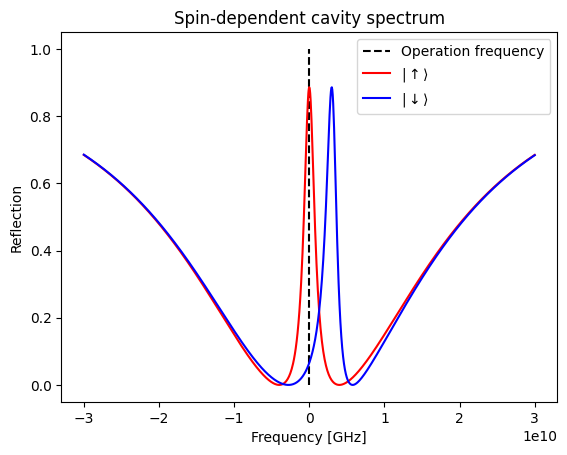

In [14]:
fig, ax = plt.subplots()

ax.vlines(parameters["f_operation"], 0, 1, label = 'Operation frequency', color = 'k', linestyle='--')
ax.plot(frequencies, np.abs(r_up)**2, label = r"$|\uparrow\rangle$", color = 'r')
ax.plot(frequencies, np.abs(r_down)**2, label = r"$|\downarrow\rangle$", color = 'b')

ax.set_title('Spin-dependent cavity spectrum')
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Reflection')
plt.legend()

This deviates from the ideal case, as at the operation frequency the reflectivity for spin up is not perfectly 1 and for spin down is not perfectly zero. 
Indeed we are interested in what fidelity we can achieve with this configuration.

First, we need to change the SPI LBB:

In [15]:
def conditional_amplitude_reflection_time_bin_spi(
    dm_in,
    spin_name,
    photon_early_name,
    photon_late_name,
    dim,
    atom_centered=True,
    f_operation=None,
    kappa_r=None,
    kappa_t=None,
    kappa_loss=0,
    gamma=None,
    delta=None,
    splitting=None,
    g=None,
    ideal=False,
    gamma_dephasing=0,
    **kw,
):

    #We just chhange how we get the reflection coefficients, which now are taken from the quantum optical modeling
    C = 4 * g**2 / (kappa_t + kappa_r + kappa_loss) / (gamma + gamma_dephasing)

    t_u, r_u, l_u = qom.cavity_qom_cavity_centered(
                f_operation, delta, kappa_r, kappa_t, kappa_loss, gamma, C, gamma_dephasing=gamma_dephasing
            )
    t_d, r_d, l_d = qom.cavity_qom_cavity_centered(
                f_operation, delta - splitting, kappa_r, kappa_t, kappa_loss, gamma, C, gamma_dephasing=gamma_dephasing
            )


    # We provide the parameters to the Physical Building Block of a conditional amplitude reflection SPI
    cav = pbb.conditional_amplitude_reflection(r_u, t_u, l_u, r_d, t_d, l_d, dim=dim)

    # Specifying which Spin it refers to.
    cav.rename("spin", spin_name)

    # We realise PBB implementation of the LBB, first the cavity is applied to Early
    cav.rename("R", photon_early_name)
    cav.rename("T", "loss_transmission")
    cav.rename("loss", "loss")

    dm_E_full = cav * dm_in * cav.dag()

    # Tracing out the lost modes
    dm_E = lbb.trace_out_loss_modes(dm_E_full)

    # We apply a pi rotation on the spin
    RX_pi = nq.NQobj([[0, 1], [1, 0]], names=spin_name, kind="oper")

    # And we apply the same cavity PBB to Late by renaming the photonic mode it operates on
    cav.rename(photon_early_name, photon_late_name)
    dm_L_full = cav * (RX_pi * dm_E * RX_pi.dag()) * cav.dag()

    #Finally we trace out the lost modes.
    dm_L = lbb.trace_out_loss_modes(dm_L_full)

    #Finally, we return the modified density matrix
    return dm_L

We can the redefine the protocol:

In [16]:
class ExampleProtocol(Protocol):
    """ 
        Our protocol class to simulate Spin-Photon Entanglement
    """
    def __init__(self, parameters: dict):
        super().__init__(parameters)

        # We prepare the initial state of the spins in |x >
        self.dm_init = nq.tensor(nq.name(st.x_dm, "Alice", "state"), nq.name(st.x_dm, "Bob", "state"))

        # We definet the two herald state projectors.
        self.herald_projectors = [
            no_vacuum_projector(name="E", dim=self.dim),
            no_vacuum_projector(name="L", dim=self.dim),
        ]

        # And the corresponding target entangled states

        state_uu = nq.tensor(nq.name(st.up, "Alice", "state"), nq.name(st.up, "Bob", "state"))
        state_dd = nq.tensor(nq.name(st.down, "Alice", "state"), nq.name(st.down, "Bob", "state"))
        
        self.target_states = [
            (state_uu + state_dd).unit(), 
            (state_uu - state_dd).unit()
        ]
        

    def protocol_sequence(self):
        self.do_lbb(lbb.photon_source_time_bin, photon_early_name="E", photon_late_name="L")

        self.do_lbb(
            conditional_amplitude_reflection_time_bin_spi,
            photon_early_name="E",
            photon_late_name="L",
            spin_name="Alice",
        )

        self.do_lbb(
            conditional_amplitude_reflection_time_bin_spi,
            photon_early_name="E",
            photon_late_name="L",
            spin_name="Bob",
        )

        self.do_lbb(lbb.basis_rotation, photon_names=["E", "L"])


And we run it with the same parameters we have shown before

In [17]:
p = ExampleProtocol(parameters)
p.run()

print( f"The Fidelities for the two herald states are: [{p.fidelity[0]:.3f}, {p.fidelity[1]:.3f}] and the Success Probability: [{p.rate[0]:.3f}, {p.rate[1]:.3f}] ")

The Fidelities for the two herald states are: [0.747, 1.000] and the Success Probability: [0.115, 0.111] 


The protocol was successful, as we can see one of the two states has higher fidelity than the other (this is expected when the two nodes have equal parameters because the errors on $|\psi_-\rangle$ cancel out [2]).

The total fidelity and rate the protocol calculates is the weighted average over the success probability of the two fidelities)

In [18]:
print(f"Total fidelity: {p.fidelity_total:.3f}, total Success Probability: {p.rate_total:.3f}")

Total fidelity: 0.871, total Success Probability: 0.226


### References

[1] H.K.C. Beukers, M. Pasini, H. Choi et. al., (2023) 'Tutorial: Remote entanglement protocols for stationary qubits with photonic interface', link


[2] C.M. Knaut, A. Suleymanzade, Y.-C. Wei, D. R. Assumpcao, P.-J. Stas et al. (2023) ‘Entanglement of Nanophotonic Quantum Memory Nodes in a Telecommunication Network’. arXiv. Available at: https://doi.org/10.48550/arXiv.2310.01316.


